In [1]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import normalize
from sklearn.linear_model import LinearRegression, RANSACRegressor

from scipy import stats

import joblib

import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.cbook as cbook
import matplotlib.colors as colors

from netCDF4 import Dataset, num2date, date2num
import os

import seaborn as sns
import cmocean as cmocn

%matplotlib inline

In [2]:
fname = '../generalStatistics/goodData_QSwithTAO_with2hrStatsConv.nc'
ds = xr.open_dataset(fname)
ds['mean_WVEL'] = np.sqrt(ds['mean_U10N_x'] **2 + ds['mean_U10N_y']**2)

In [3]:
#ds = xr.open_dataset('../rainFlagRemovedBuoyDataBadQualityRemovedMatchup.nc')
metop = 'MetOP_A'
dsA = xr.open_dataset(f'/srv/data2/srai_poseidon/srai_poseidon/observation/SatelliteVsBuoy/codes/ASCATprocessing/jupyter/rainFlagRemovedBuoyDataBadQualityRemovedMatchup_MetOP_A.nc')
dsB = xr.open_dataset(f'/srv/data2/srai_poseidon/srai_poseidon/observation/SatelliteVsBuoy/codes/ASCATprocessing/jupyter/rainFlagRemovedBuoyDataBadQualityRemovedMatchup_MetOP_B.nc')
dsB['count'] = dsB['count'] + np.max(dsA['count'].to_numpy()) + 1

ds_AS = xr.concat([dsA, dsB], dim='count')

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


In [8]:
data = ds.to_dataframe()
df = data.copy()

In [9]:
data_AS = ds_AS.to_dataframe()
df_AS = data_AS.copy()

In [10]:
ds

<xarray.Dataset>
Dimensions:                                                     (count: 148300)
Coordinates:
  * count                                                       (count) int64 ...
Data variables: (12/88)
    Wind Direction (TAO)                                        (count) float32 ...
    WDIR_QC                                                     (count) float32 ...
    WDIR_DM                                                     (count) |S1 b...
    Wind Speed (TAO)                                            (count) float32 ...
    WSPD_QC                                                     (count) float32 ...
    WSPD_DM                                                     (count) |S1 b...
    ...                                                          ...
    Direction Difference (QuikSCAT - TAO 2hr mean)              (count) float64 ...
    cos(Direction Difference (QuikSCAT - TAO 2hr mean))         (count) float64 ...
    sin(Direction Difference (QuikSCAT - TAO 2hr mean))         (count) float64 ...
    Zonal Wind Speed Difference (QuikSCAT - TAO 2hr mean)       (count) float64 ...
    Meridional Wind Speed Difference (QuikSCAT - TAO 2hr mean)  (count) float64 ...
    mean_WVEL                                                   (count) float64 ...

In [11]:
ds_AS

<xarray.Dataset>
Dimensions:                                         (count: 75155)
Coordinates:
  * count                                           (count) int64 0 1 ... 75595
Data variables: (12/57)
    Wind Direction (TAO)                            (count) float32 122.0 ......
    WDIR_QC                                         (count) float32 2.0 ... 1.0
    WDIR_DM                                         (count) |S1 b'D' ... b'D'
    Wind Speed (TAO)                                (count) float32 7.01 ... ...
    WSPD_QC                                         (count) float32 2.0 ... 1.0
    WSPD_DM                                         (count) |S1 b'D' ... b'D'
    ...                                              ...
    Meridional Wind Speed (ASCAT)                   (count) float64 4.831 ......
    Direction Difference (ASCAT - TAO)              (count) float64 14.9 ... ...
    cos(Direction Difference (ASCAT - TAO))         (count) float64 0.9664 .....
    sin(Direction Difference (ASCAT - TAO))         (count) float64 0.2571 .....
    Zonal Wind Speed Difference (ASCAT - TAO)       (count) float64 -1.105 .....
    Meridional Wind Speed Difference (ASCAT - TAO)  (count) float64 -1.663 .....

In [12]:
selectX = ['Speed Difference (QuikSCAT - TAO)',
          'cos(Direction Difference (QuikSCAT - TAO))',
          'sin(Direction Difference (QuikSCAT - TAO))']

X = df[selectX]

normX = (X - X.mean(axis=0))/ X.std(axis=0)

dbscan = DBSCAN(eps=0.15, min_samples= 500)
df['label'] = dbscan.fit_predict(normX)

In [13]:
# load trained model 
classifier = joblib.load("../../classification_machineLearning/randomForest/random_forest_rainDetection.joblib")

# Features used for classification
features = ['mean_WSPD', 'mean_SST', 'mean_AIRT', 'mean_SST - AIRT', 'mean_RELH', 'std_WSPD', 'std_cosWDIR', 'std_sinWDIR', 'std_SST', 'std_AIRT', 'std_SST - AIRT', 'std_RELH']
X = df[features]

#predict rain flags
y_pred = classifier.predict(X)
df['predicted_rain_flag'] = y_pred

In [15]:
selectX_AS = ['Speed Difference (ASCAT - TAO)',
          'cos(Direction Difference (ASCAT - TAO))',
          'sin(Direction Difference (ASCAT - TAO))']

X_AS = df_AS[selectX_AS]

normX_AS = (X_AS - X_AS.mean(axis=0))/ X_AS.std(axis=0)

#dbscan = DBSCAN(eps=0.15, min_samples= 500) ## for QuikSCAT
dbscan_AS = DBSCAN(eps=0.21, min_samples= 500)
df_AS['label'] = dbscan_AS.fit_predict(normX_AS)

In [18]:
mask_AS = np.isnan(df_AS[features[0]])

for ftr in features:
    mask_AS += np.isnan(df_AS[ftr])

df_AS = df_AS.loc[~mask_AS]

X_AS = df_AS[features]

#predict rain flags
y_pred_AS = classifier.predict(X_AS)
df_AS['predicted_rain_flag'] = y_pred_AS

In [49]:
def plotQS(subDF, axes):
    Ux_QS = np.array(subDF['Zonal Wind Speed (QuikSCAT)'])
    Uy_QS = np.array(subDF['Meridional Wind Speed (QuikSCAT)'])
    
    Ux_TAO = np.array(subDF['Zonal Neutral Wind Speed (TAO)'])
    Uy_TAO = np.array(subDF['Meridional Neutral Wind Speed (TAO)'])
    
    QS = Ux_QS + 1j * Uy_QS
    TAO = Ux_TAO + 1j *Uy_TAO
    
    r = QS/TAO
    angle = np.angle(r, deg=True)
    ratio = np.abs(r)
    subDF['angle_diff'] = angle
    subDF['ratio'] = ratio

    subDF['corrected_angle_diff'] = angle
    subDF['Zonal Neutral Wind Speed (TAO) aft. correc.'] = subDF['Zonal Neutral Wind Speed (TAO)']
    subDF['Meridional Neutral Wind Speed (TAO) aft. correc.'] = subDF['Meridional Neutral Wind Speed (TAO)']

    mask = np.logical_or(np.isnan(ratio), abs(ratio) > 100)
    subDF = subDF.loc[~mask]

    subDF2 = subDF.loc[subDF['label'] == -1]
    subDF = subDF.loc[subDF['label'] == 0]
    
    deployments = subDF['Deployment index']
    dep_labels = np.unique(np.array(deployments))
    startDates = []
    endDates = []
    
    for dep in dep_labels:
        ssubDF = subDF.loc[subDF['Deployment index'] == dep]
        
        startDates.append(np.min(ssubDF['QS_TIME']))
        endDates.append(np.max(ssubDF['QS_TIME']))
        
        x = ((np.array(ssubDF['QS_TIME']) - np.datetime64('2000-01-01T00:00:00'))/np.timedelta64(1,'m')).reshape(-1,1)    
        y = np.array(ssubDF['ratio']).reshape(-1,1)

        if len(x) <2:
            continue
    
        ransac = RANSACRegressor(random_state=42)
        ransac.fit(x, y)
        Y = ransac.predict(x)
        axes[0].plot(ssubDF['QS_TIME'], Y, color='k')    
        y = np.array(ssubDF['angle_diff']).reshape(-1,1)
    
        ransac = RANSACRegressor(random_state=42)
        ransac.fit(x, y)
        Y = ransac.predict(x)
        axes[1].plot(ssubDF['QS_TIME'], Y, color='k')
        
        y -= Y #- np.mean(Y)) 
        ransac.fit(x, y)
        Y = ransac.predict(x)
        axes[2].plot(ssubDF['QS_TIME'], Y, color='k')
        
        # ssubDF.loc[:,'corrected_angle_diff'] = y[:,0]
        # ssubDF.loc[:,'corrected_angle'] = ssubDF['Wind Direction (QuikSCAT)'] - ssubDF['corrected_angle_diff']

        # Ux_TAO = ssubDF['Neutral Wind Speed at 10m (TAO)'] * np.cos(np.deg2rad(ssubDF['corrected_angle']))
        # Uy_TAO = ssubDF['Neutral Wind Speed at 10m (TAO)'] * np.sin(np.deg2rad(ssubDF['corrected_angle']))
        # subDF.loc[subDF['Deployment index'] == dep, 'Zonal Neutral Wind Speed (TAO) aft. correc.'] = Ux_TAO
        # subDF.loc[subDF['Deployment index'] == dep, 'Meridional Neutral Wind Speed (TAO) aft. correc.'] = Uy_TAO
        subDF.loc[subDF['Deployment index'] == dep, 'corrected_angle_diff'] = y[:,0]
        
    ax = axes[0]
    ax.scatter(subDF['QS_TIME'], subDF['ratio'], c = 'r', s = 0.2)
    ax.scatter(subDF2['QS_TIME'], subDF2['ratio'], c = 'grey', s = 0.4)
    
    ax = axes[1]
    ax.scatter(subDF['QS_TIME'], subDF['angle_diff'], c = 'r', s = 0.2)
    ax.scatter(subDF2['QS_TIME'], subDF2['angle_diff'], c = 'grey', s = 0.4)

    ax = axes[2]
    ax.scatter(subDF['QS_TIME'], subDF['corrected_angle_diff'], c = 'r', s = 0.2)

    
    for i in range(len(startDates)):
        colorR =list(np.random.choice(range(256), size=3)/256)
        
        axes[0].axvspan(startDates[i], endDates[i], 
                   alpha=0.05, color=colorR)
        axes[1].axvspan(startDates[i], endDates[i], 
                   alpha=0.05, color=colorR)
        axes[2].axvspan(startDates[i], endDates[i], 
                   alpha=0.05, color=colorR)
    
    axes[0].set_ylim(0,2)
    axes[1].set_ylim(-50,50)
    axes[2].set_ylim(-50,50)
    
    axes[0].set_title('Ratio of wind speeds (QS/TAO)')
    axes[1].set_title('Difference in wind direction (QS - TAO)')
    axes[2].set_title('Difference in wind direction (QS - TAO) after correction from robust regression fit')

    axes[0].grid(axis='y')
    axes[1].grid(axis='y')
    axes[2].grid(axis='y')


In [50]:
def plotAS(subDF, axes):
    Ux_AS = np.array(subDF['Zonal Wind Speed (ASCAT)'])
    Uy_AS = np.array(subDF['Meridional Wind Speed (ASCAT)'])
    
    Ux_TAO = np.array(subDF['Zonal Neutral Wind Speed (TAO)'])
    Uy_TAO = np.array(subDF['Meridional Neutral Wind Speed (TAO)'])
    
    AS = Ux_AS + 1j * Uy_AS
    TAO = Ux_TAO + 1j *Uy_TAO
    
    r = AS/TAO
    angle = np.angle(r, deg=True)
    ratio = np.abs(r)
    subDF['angle_diff'] = angle
    subDF['ratio'] = ratio

    subDF['corrected_angle_diff'] = angle
    subDF['Zonal Neutral Wind Speed (TAO) aft. correc.'] = subDF['Zonal Neutral Wind Speed (TAO)']
    subDF['Meridional Neutral Wind Speed (TAO) aft. correc.'] = subDF['Meridional Neutral Wind Speed (TAO)']

    mask = np.logical_or(np.isnan(ratio), abs(ratio) > 100)
    subDF = subDF.loc[~mask]

    subDF2 = subDF.loc[subDF['label'] == -1]
    subDF = subDF.loc[subDF['label'] == 0]
    
    deployments = subDF['Deployment index']
    dep_labels = np.unique(np.array(deployments))
    startDates = []
    endDates = []
    
    for dep in dep_labels:
        ssubDF = subDF.loc[subDF['Deployment index'] == dep]
        
        startDates.append(np.min(ssubDF['AS_TIME']))
        endDates.append(np.max(ssubDF['AS_TIME']))
        
        x = ((np.array(ssubDF['AS_TIME']) - np.datetime64('2000-01-01T00:00:00'))/np.timedelta64(1,'m')).reshape(-1,1)    
        y = np.array(ssubDF['ratio']).reshape(-1,1)

        if len(x) <2:
            continue
    
        ransac = RANSACRegressor(random_state=42)
        ransac.fit(x, y)
        Y = ransac.predict(x)
        axes[0].plot(ssubDF['AS_TIME'], Y, color='k')    
        y = np.array(ssubDF['angle_diff']).reshape(-1,1)
    
        ransac = RANSACRegressor(random_state=42)
        ransac.fit(x, y)
        Y = ransac.predict(x)
        axes[1].plot(ssubDF['AS_TIME'], Y, color='k')
        
        y -= Y #(Y - np.mean(Y)) 
        ransac.fit(x, y)
        Y = ransac.predict(x)
        axes[2].plot(ssubDF['AS_TIME'], Y, color='k')
        
        # ssubDF.loc[:,'corrected_angle_diff'] = y[:,0]
        # ssubDF.loc[:,'corrected_angle'] = ssubDF['Wind Direction (ASCAT)'] - ssubDF['corrected_angle_diff']

        # Ux_TAO = ssubDF['Neutral Wind Speed at 10m (TAO)'] * np.cos(np.deg2rad(ssubDF['corrected_angle']))
        # Uy_TAO = ssubDF['Neutral Wind Speed at 10m (TAO)'] * np.sin(np.deg2rad(ssubDF['corrected_angle']))
        # subDF.loc[subDF['Deployment index'] == dep, 'Zonal Neutral Wind Speed (TAO) aft. correc.'] = Ux_TAO
        # subDF.loc[subDF['Deployment index'] == dep, 'Meridional Neutral Wind Speed (TAO) aft. correc.'] = Uy_TAO
        subDF.loc[subDF['Deployment index'] == dep, 'corrected_angle_diff'] = y[:,0]
        
    ax = axes[0]
    ax.scatter(subDF['AS_TIME'], subDF['ratio'], c = 'r', s = 0.2)
    ax.scatter(subDF2['AS_TIME'], subDF2['ratio'], c = 'grey', s = 0.4)
    
    ax = axes[1]
    ax.scatter(subDF['AS_TIME'], subDF['angle_diff'], c = 'r', s = 0.2)
    ax.scatter(subDF2['AS_TIME'], subDF2['angle_diff'], c = 'grey', s = 0.4)

    ax = axes[2]
    ax.scatter(subDF['AS_TIME'], subDF['corrected_angle_diff'], c = 'r', s = 0.2)

    
    for i in range(len(startDates)):
        colorR =list(np.random.choice(range(256), size=3)/256)
        
        axes[0].axvspan(startDates[i], endDates[i], 
                   alpha=0.05, color=colorR)
        axes[1].axvspan(startDates[i], endDates[i], 
                   alpha=0.05, color=colorR)
        axes[2].axvspan(startDates[i], endDates[i], 
                   alpha=0.05, color=colorR)
    
    axes[0].set_ylim(0,2)
    axes[1].set_ylim(-50,50)
    axes[2].set_ylim(-50,50)
    
    axes[0].set_title('Ratio of wind speeds (AS/TAO)')
    axes[1].set_title('Difference in wind direction (AS - TAO)')
    axes[2].set_title('Difference in wind direction (AS - TAO) after correction from robust regression fit')

    axes[0].grid(axis='y')
    axes[1].grid(axis='y')
    axes[2].grid(axis='y')

In [51]:
def plotSusanLikeWithCorrectedAngle(SUBDF, SUBDF_AS, lat, lon, suffix='all'):

    subDF = SUBDF.loc[SUBDF['LATITUDE'] == lat]
    subDF = subDF.loc[SUBDF['LONGITUDE'] == (lon+360)%360]

    if len(subDF.index) <1:
        return None


    subDF_AS = SUBDF_AS.loc[SUBDF_AS['LATITUDE'] == lat]
    subDF_AS = subDF_AS.loc[SUBDF_AS['LONGITUDE'] == (lon+360)%360]

    if len(subDF_AS.index) <1:
        return None
        
    fig, axess = plt.subplots(nrows=3, ncols=2, figsize=(20,12))

    axes = axess[:,0]
    plotQS(subDF, axes)

    axes = axess[:,1]
    plotAS(subDF_AS, axes)

    if lat < 0:
        latUnits = 'S'
        lat = abs(lat)
    else:
        latUnits = 'N'
    
    if lon < 0:
        lonUnits = 'W'
        lon = abs(lon) # 360
    else:
        lonUnits = 'E'
    
    
    title = f'images/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_{suffix}.png'
    plt.savefig(title, dpi = 100)
    plt.close()

In [52]:
def plotSusanLikeWithCorrectedAngleGreyBad(SUBDF, lat, lon, suffix='all'):
    subDF = SUBDF.loc[SUBDF['LATITUDE'] == lat]
    subDF = subDF.loc[SUBDF['LONGITUDE'] == (lon+360)%360]

    if len(subDF.index) <1:
        return
    
    Ux_QS = np.array(subDF['Zonal Wind Speed (QuikSCAT)'])
    Uy_QS = np.array(subDF['Meridional Wind Speed (QuikSCAT)'])
    
    Ux_TAO = np.array(subDF['Zonal Neutral Wind Speed (TAO)'])
    Uy_TAO = np.array(subDF['Meridional Neutral Wind Speed (TAO)'])
    
    QS = Ux_QS + 1j * Uy_QS
    TAO = Ux_TAO + 1j *Uy_TAO
    
    r = QS/TAO
    angle = np.angle(r, deg=True)
    ratio = np.abs(r)
    subDF['angle_diff'] = angle
    subDF['ratio'] = ratio

    subDF['corrected_angle_diff'] = angle
    subDF['Zonal Neutral Wind Speed (TAO) aft. correc.'] = subDF['Zonal Neutral Wind Speed (TAO)']
    subDF['Meridional Neutral Wind Speed (TAO) aft. correc.'] = subDF['Meridional Neutral Wind Speed (TAO)']

    mask = np.logical_or(np.isnan(ratio), abs(ratio) > 100)
    subDF = subDF.loc[~mask]


    subDF2 = subDF.loc[subDF['label'] == -1]
    subDF = subDF.loc[subDF['label'] == 0]
    
    deployments = subDF['Deployment index']
    dep_labels = np.unique(np.array(deployments))
    startDates = []
    endDates = []
        
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(20,12))
    
    for dep in dep_labels:
        ssubDF = subDF.loc[subDF['Deployment index'] == dep]
        
        startDates.append(np.min(ssubDF['QS_TIME']))
        endDates.append(np.max(ssubDF['QS_TIME']))
        
        x = ((np.array(ssubDF['QS_TIME']) - np.datetime64('2000-01-01T00:00:00'))/np.timedelta64(1,'m')).reshape(-1,1)    
        y = np.array(ssubDF['ratio']).reshape(-1,1)

        if len(x) <2:
            continue
    
        ransac = RANSACRegressor(random_state=42)
        ransac.fit(x, y)
        Y = ransac.predict(x)
        axes[0].plot(ssubDF['QS_TIME'], Y, color='k')    
        y = np.array(ssubDF['angle_diff']).reshape(-1,1)
    
        ransac = RANSACRegressor(random_state=42)
        ransac.fit(x, y)
        Y = ransac.predict(x)
        axes[1].plot(ssubDF['QS_TIME'], Y, color='k')
        
        y -= (Y - np.mean(Y)) 
        ransac.fit(x, y)
        Y = ransac.predict(x)
        axes[2].plot(ssubDF['QS_TIME'], Y, color='k')
        
        # ssubDF.loc[:,'corrected_angle_diff'] = y[:,0]
        # ssubDF.loc[:,'corrected_angle'] = ssubDF['Wind Direction (QuikSCAT)'] - ssubDF['corrected_angle_diff']

        # Ux_TAO = ssubDF['Neutral Wind Speed at 10m (TAO)'] * np.cos(np.deg2rad(ssubDF['corrected_angle']))
        # Uy_TAO = ssubDF['Neutral Wind Speed at 10m (TAO)'] * np.sin(np.deg2rad(ssubDF['corrected_angle']))
        # subDF.loc[subDF['Deployment index'] == dep, 'Zonal Neutral Wind Speed (TAO) aft. correc.'] = Ux_TAO
        # subDF.loc[subDF['Deployment index'] == dep, 'Meridional Neutral Wind Speed (TAO) aft. correc.'] = Uy_TAO
        subDF.loc[subDF['Deployment index'] == dep, 'corrected_angle_diff'] = y[:,0]
        
    ax = axes[0]
    ax.scatter(subDF['QS_TIME'], subDF['ratio'], c = 'r', s = 0.2)
    ax.scatter(subDF2['QS_TIME'], subDF2['ratio'], c = 'grey', s = 0.4)
    
    ax = axes[1]
    ax.scatter(subDF['QS_TIME'], subDF['angle_diff'], c = 'r', s = 0.2)
    ax.scatter(subDF2['QS_TIME'], subDF2['angle_diff'], c = 'grey', s = 0.4)

    ax = axes[2]
    ax.scatter(subDF['QS_TIME'], subDF['corrected_angle_diff'], c = 'r', s = 0.2)
    #ax.scatter(subDF2['QS_TIME'], subDF2['angle_diff'], c = 'grey', s = 0.4)

    
    for i in range(len(startDates)):
        colorR =list(np.random.choice(range(256), size=3)/256)
        
        axes[0].axvspan(startDates[i], endDates[i], 
                   alpha=0.05, color=colorR)
        axes[1].axvspan(startDates[i], endDates[i], 
                   alpha=0.05, color=colorR)
        axes[2].axvspan(startDates[i], endDates[i], 
                   alpha=0.05, color=colorR)
    
    axes[0].set_ylim(0,2)
    axes[1].set_ylim(-50,50)
    axes[2].set_ylim(-50,50)
    
    axes[0].set_title('Ratio of wind speeds (QS/TAO)')
    axes[1].set_title('Difference in wind direction (QS - TAO)')
    axes[2].set_title('Difference in wind direction (QS - TAO) after correction from robust regression fit')

    axes[0].grid(axis='y')
    axes[1].grid(axis='y')
    axes[2].grid(axis='y')
    
    if lat < 0:
        latUnits = 'S'
        lat = abs(lat)
    else:
        latUnits = 'N'
    
    if lon < 0:
        lonUnits = 'W'
        lon = abs(lon) # 360
    else:
        lonUnits = 'E'
    title = f'T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_{suffix}.png'
    plt.savefig(title, dpi = 100)
    plt.close()

In [53]:
latList = [-9, -8, -5, -2, 0, 2, 5, 8, 9]
lonList = [-95, -110, -125, -140, -155, -170, -180, 165]

ylen = len(latList)
xlen = len(lonList)

taskList = []

for latId  in range(ylen):
    for lonId in range(xlen):
        taskList.append([latList[latId], lonList[lonId]])

ntasks = len(taskList)

In [56]:
# subDF = df.loc[df['predicted_rain_flag'] == 0]
# subDF = subDF.loc[subDF['label'] == 0]

# subDF_AS = df_AS.loc[df_AS['predicted_rain_flag'] == 0]
# subDF_AS = subDF_AS.loc[subDF_AS['label'] == 0]

# for i in range(ntasks):
#     lat = taskList[i][0]
#     lon = taskList[i][1]
#     plotSusanLikeWithoutCorrectedAngle(subDF, lat, lon, suffix='dryAndGoodWithoutCorrection')

# for i in range(ntasks):
#     lat = taskList[i][0]
#     lon = taskList[i][1]
#     plotSusanLikeWithCorrectedAngle(subDF, lat, lon, suffix='dryAndGoodWithAngleCorrection')

for i in range(ntasks):
    lat = taskList[i][0]
    lon = taskList[i][1]
    plotSusanLikeWithCorrectedAngle(df, df_AS, lat, lon, suffix='dryAndGoodWithAngleCorrection')

/tmp/ipykernel_417554/3588449597.py:11: RuntimeWarning: divide by zero encountered in divide
  r = AS/TAO
/tmp/ipykernel_417554/2060606964.py:11: RuntimeWarning: divide by zero encountered in divide
  r = QS/TAO
/tmp/ipykernel_417554/2060606964.py:11: RuntimeWarning: invalid value encountered in divide
  r = QS/TAO
/tmp/ipykernel_417554/2060606964.py:11: RuntimeWarning: divide by zero encountered in divide
  r = QS/TAO
/tmp/ipykernel_417554/2060606964.py:11: RuntimeWarning: invalid value encountered in divide
  r = QS/TAO
/tmp/ipykernel_417554/2060606964.py:11: RuntimeWarning: divide by zero encountered in divide
  r = QS/TAO
/tmp/ipykernel_417554/2060606964.py:11: RuntimeWarning: invalid value encountered in divide
  r = QS/TAO
/tmp/ipykernel_417554/2060606964.py:11: RuntimeWarning: divide by zero encountered in divide
  r = QS/TAO
/tmp/ipykernel_417554/2060606964.py:11: RuntimeWarning: divide by zero encountered in divide
  r = QS/TAO
/tmp/ipykernel_417554/2060606964.py:11: RuntimeWa

In [57]:
def getSlopeInterceptOffsetSpeedRatioDirectionDiff(SUBDF, lat, lon):
    subDF = SUBDF.loc[SUBDF['LATITUDE'] == lat]
    subDF = subDF.loc[SUBDF['LONGITUDE'] == (lon+360)%360]

    if len(subDF.index) <1:
        return None
    
    Ux_QS = np.array(subDF['Zonal Wind Speed (QuikSCAT)'])
    Uy_QS = np.array(subDF['Meridional Wind Speed (QuikSCAT)'])
    
    Ux_TAO = np.array(subDF['Zonal Neutral Wind Speed (TAO)'])
    Uy_TAO = np.array(subDF['Meridional Neutral Wind Speed (TAO)'])
    
    QS = Ux_QS + 1j * Uy_QS
    TAO = Ux_TAO + 1j *Uy_TAO
    
    r = QS/TAO
    angle = np.angle(r, deg=True)
    ratio = np.abs(r)
    subDF['angle_diff'] = angle
    subDF['ratio'] = ratio
    subDF['speed_diff'] = subDF['Wind Speed (QuikSCAT)'] - subDF['Neutral Wind Speed at 10m (TAO)']

    subDF['corrected_angle_diff'] = angle
    subDF['Zonal Neutral Wind Speed (TAO) aft. correc.'] = subDF['Zonal Neutral Wind Speed (TAO)']
    subDF['Meridional Neutral Wind Speed (TAO) aft. correc.'] = subDF['Meridional Neutral Wind Speed (TAO)']

    mask = np.logical_or(np.isnan(ratio), abs(ratio) > 100)
    subDF = subDF.loc[~mask]

    subDF2 = subDF.loc[subDF['label'] == -1]
    subDF = subDF.loc[subDF['label'] == 0]
    
    deployments = subDF['Deployment index']
    dep_labels = np.unique(np.array(deployments))

    dep_indx =[]
    startDates = []
    endDates = []
    
    speedRatio_slopes = []
    speedRatio_intercepts = []
    speedRatio_offsets = []
    speedRatio_r_value = []
    speedRatio_p_value = []
    speedRatio_std_err = []

    speedDiff_slopes = []
    speedDiff_intercepts = []
    speedDiff_offsets = []
    speedDiff_r_value = []
    speedDiff_p_value = []
    speedDiff_std_err = []

    direcDiff_slopes = []
    direcDiff_intercepts = []
    direcDiff_offsets = []
    direcDiff_r_value = []
    direcDiff_p_value = []
    direcDiff_std_err = []
        
    
    for dep in dep_labels:
        ssubDF = subDF.loc[subDF['Deployment index'] == dep]
        if len(ssubDF) <5:
            continue

        startDates.append(pd.to_datetime(np.min(ssubDF['QS_TIME'])))
        endDates.append(pd.to_datetime(np.max(ssubDF['QS_TIME'])))

        ### Rergression for speed ratio
        x = ( (np.array(ssubDF['QS_TIME']) - np.datetime64(np.min(ssubDF['QS_TIME'])))/np.timedelta64(1,'D')).reshape(-1,1)
        x[x<1] = 0
        #print('np.min(x), np.max(x)', np.min(x), np.max(x))
        y = np.array(ssubDF['ratio']).reshape(-1,1)

        #print('speed ratio np.min(y), np.max(y)', np.min(y), np.max(y))

        dep_indx.append(dep)
            
        ransac = RANSACRegressor(random_state=42)
        ransac.fit(x, y)

        ### plotting line
        Y = ransac.predict(x)
        ## axes[0].plot(ssubDF['QS_TIME'], Y, color='k') 

        slope, intercept, r_value, p_value, std_err = stats.linregress(x[:,0], Y[:,0])
        speedRatio_slopes.append(slope)
        speedRatio_intercepts.append(intercept)
        speedRatio_offsets.append(np.mean(Y))
        speedRatio_r_value.append(r_value)
        speedRatio_p_value.append(p_value)
        speedRatio_std_err.append(std_err)


        ### Regression for speed difference
        y = np.array(ssubDF['speed_diff']).reshape(-1,1)

        #print('speed diff np.min(y), np.max(y)', np.min(y), np.max(y))
        ransac = RANSACRegressor(random_state=42)
        ransac.fit(x, y)

        ### plotting line
        Y = ransac.predict(x)
        #axes[1].plot(ssubDF['QS_TIME'], Y, color='k')

        slope, intercept, r_value, p_value, std_err = stats.linregress(x[:,0], Y[:,0])
        speedDiff_slopes.append(slope)
        speedDiff_intercepts.append(intercept)
        speedDiff_offsets.append(np.mean(Y))
        speedDiff_r_value.append(r_value)
        speedDiff_p_value.append(p_value)
        speedDiff_std_err.append(std_err)


        ### Regression for direction difference
        y = np.array(ssubDF['angle_diff']).reshape(-1,1)

        #print('direction diff np.min(y), np.max(y)', np.min(y), np.max(y))
        ransac = RANSACRegressor(random_state=42)
        ransac.fit(x, y)

        ### plotting line
        Y = ransac.predict(x)
        #axes[1].plot(ssubDF['QS_TIME'], Y, color='k')

        slope, intercept, r_value, p_value, std_err = stats.linregress(x[:,0], Y[:,0])
        direcDiff_slopes.append(slope)
        direcDiff_intercepts.append(intercept)
        direcDiff_offsets.append(np.mean(Y))
        direcDiff_r_value.append(r_value)
        direcDiff_p_value.append(p_value)
        direcDiff_std_err.append(std_err)

    latVals = [lat for i in dep_indx]
    lonVals = [(lon+360)%360 for i in dep_indx]

    # print('lat, lon', lat, lon)

    # print('latVals', len(latVals), '\n',
    #       'lonVals', len(lonVals), '\n',
    #       'dep_indx', len(dep_indx), '\n',
    #       'startDates', len(startDates), '\n',
    #       'endDates', len(endDates), '\n',
    #       'speedRatio_slopes', len(speedRatio_slopes), '\n',
    #       'speedRatio_intercepts', len(speedRatio_intercepts), '\n',
    #       'speedRatio_offsets', len(speedRatio_offsets), '\n',
    #       'speedRatio_r_value', len(speedRatio_r_value), '\n',
    #       'speedRatio_p_value', len(speedRatio_p_value), '\n',
    #       'speedRatio_std_err', len(speedRatio_std_err), '\n',
    #       'direcDiff_slopes', len(direcDiff_slopes), '\n',
    #       'direcDiff_intercepts', len(direcDiff_intercepts), '\n',
    #       'direcDiff_offsets', len(direcDiff_offsets), '\n',
    #       'direcDiff_r_value', len(direcDiff_r_value), '\n',
    #       'direcDiff_p_value', len(direcDiff_p_value), '\n',
    #       'direcDiff_std_err', len(direcDiff_std_err), '\n')

    infoDict = {'LATITUDE': latVals,
                'LONGITUDE': lonVals,
                'Deployments': dep_indx,
                'Start Dates': startDates,
                'End Dates': endDates,
                'speedRatio_slopes': speedRatio_slopes,
                'speedRatio_intercepts': speedRatio_intercepts,
                'speedRatio_offsets': speedRatio_offsets,
                'speedRatio_r_value': speedRatio_r_value,
                'speedRatio_p_value': speedRatio_p_value,
                'speedRatio_std_err': speedRatio_std_err,
                'speedDiff_slopes': speedDiff_slopes,
                'speedDiff_intercepts': speedDiff_intercepts,
                'speedDiff_offsets': speedDiff_offsets,
                'speedDiff_r_value': speedDiff_r_value,
                'speedDiff_p_value': speedDiff_p_value,
                'speedDiff_std_err': speedDiff_std_err,
                'direcDiff_slopes': direcDiff_slopes,
                'direcDiff_intercepts': direcDiff_intercepts,
                'direcDiff_offsets': direcDiff_offsets,
                'direcDiff_r_value': direcDiff_r_value,
                'direcDiff_p_value': direcDiff_p_value,
                'direcDiff_std_err': direcDiff_std_err}

    outDF = pd.DataFrame(infoDict, columns = ['LATITUDE',
                                            'LONGITUDE',
                                            'Deployments',
                                            'Start Dates',
                                            'End Dates',
                                            'speedRatio_slopes',
                                            'speedRatio_intercepts',
                                            'speedRatio_offsets',
                                            'speedRatio_r_value',
                                            'speedRatio_p_value',
                                            'speedRatio_std_err',
                                            'speedDiff_slopes',
                                            'speedDiff_intercepts',
                                            'speedDiff_offsets',
                                            'speedDiff_r_value',
                                            'speedDiff_p_value',
                                            'speedDiff_std_Diff',
                                            'direcDiff_slopes',
                                            'direcDiff_intercepts',
                                            'direcDiff_offsets',
                                            'direcDiff_r_value',
                                            'direcDiff_p_value',
                                            'direcDiff_std_err'])
    return outDF
        

In [60]:
def getSlopeInterceptOffsetSpeedRatioDirectionDiff_AS(SUBDF, lat, lon):
    subDF = SUBDF.loc[SUBDF['LATITUDE'] == lat]
    subDF = subDF.loc[SUBDF['LONGITUDE'] == (lon+360)%360]

    if len(subDF.index) <1:
        return None
    
    Ux_AS = np.array(subDF['Zonal Wind Speed (ASCAT)'])
    Uy_AS = np.array(subDF['Meridional Wind Speed (ASCAT)'])
    
    Ux_TAO = np.array(subDF['Zonal Neutral Wind Speed (TAO)'])
    Uy_TAO = np.array(subDF['Meridional Neutral Wind Speed (TAO)'])
    
    AS = Ux_AS + 1j * Uy_AS
    TAO = Ux_TAO + 1j *Uy_TAO
    
    r = AS/TAO
    angle = np.angle(r, deg=True)
    ratio = np.abs(r)
    subDF['angle_diff'] = angle
    subDF['ratio'] = ratio
    subDF['speed_diff'] = subDF['Wind Speed (ASCAT)'] - subDF['Neutral Wind Speed at 10m (TAO)']

    subDF['corrected_angle_diff'] = angle
    subDF['Zonal Neutral Wind Speed (TAO) aft. correc.'] = subDF['Zonal Neutral Wind Speed (TAO)']
    subDF['Meridional Neutral Wind Speed (TAO) aft. correc.'] = subDF['Meridional Neutral Wind Speed (TAO)']

    mask = np.logical_or(np.isnan(ratio), abs(ratio) > 100)
    subDF = subDF.loc[~mask]

    subDF2 = subDF.loc[subDF['label'] == -1]
    subDF = subDF.loc[subDF['label'] == 0]
    
    deployments = subDF['Deployment index']
    dep_labels = np.unique(np.array(deployments))

    dep_indx =[]
    startDates = []
    endDates = []
    
    speedRatio_slopes = []
    speedRatio_intercepts = []
    speedRatio_offsets = []
    speedRatio_r_value = []
    speedRatio_p_value = []
    speedRatio_std_err = []

    speedDiff_slopes = []
    speedDiff_intercepts = []
    speedDiff_offsets = []
    speedDiff_r_value = []
    speedDiff_p_value = []
    speedDiff_std_err = []

    direcDiff_slopes = []
    direcDiff_intercepts = []
    direcDiff_offsets = []
    direcDiff_r_value = []
    direcDiff_p_value = []
    direcDiff_std_err = []
        
    
    for dep in dep_labels:
        ssubDF = subDF.loc[subDF['Deployment index'] == dep]
        if len(ssubDF) <5:
            continue

        startDates.append(pd.to_datetime(np.min(ssubDF['AS_TIME'])))
        endDates.append(pd.to_datetime(np.max(ssubDF['AS_TIME'])))

        ### Rergression for speed ratio
        x = ( (np.array(ssubDF['AS_TIME']) - np.datetime64(np.min(ssubDF['AS_TIME'])))/np.timedelta64(1,'D')).reshape(-1,1)
        x[x<1] = 0
        #print('np.min(x), np.max(x)', np.min(x), np.max(x))
        y = np.array(ssubDF['ratio']).reshape(-1,1)

        #print('speed ratio np.min(y), np.max(y)', np.min(y), np.max(y))

        dep_indx.append(dep)
            
        ransac = RANSACRegressor(random_state=42)
        ransac.fit(x, y)

        ### plotting line
        Y = ransac.predict(x)
        ## axes[0].plot(ssubDF['AS_TIME'], Y, color='k') 

        slope, intercept, r_value, p_value, std_err = stats.linregress(x[:,0], Y[:,0])
        speedRatio_slopes.append(slope)
        speedRatio_intercepts.append(intercept)
        speedRatio_offsets.append(np.mean(Y))
        speedRatio_r_value.append(r_value)
        speedRatio_p_value.append(p_value)
        speedRatio_std_err.append(std_err)


        ### Regression for speed difference
        y = np.array(ssubDF['speed_diff']).reshape(-1,1)

        #print('speed diff np.min(y), np.max(y)', np.min(y), np.max(y))
        ransac = RANSACRegressor(random_state=42)
        ransac.fit(x, y)

        ### plotting line
        Y = ransac.predict(x)
        #axes[1].plot(ssubDF['AS_TIME'], Y, color='k')

        slope, intercept, r_value, p_value, std_err = stats.linregress(x[:,0], Y[:,0])
        speedDiff_slopes.append(slope)
        speedDiff_intercepts.append(intercept)
        speedDiff_offsets.append(np.mean(Y))
        speedDiff_r_value.append(r_value)
        speedDiff_p_value.append(p_value)
        speedDiff_std_err.append(std_err)


        ### Regression for direction difference
        y = np.array(ssubDF['angle_diff']).reshape(-1,1)

        #print('direction diff np.min(y), np.max(y)', np.min(y), np.max(y))
        ransac = RANSACRegressor(random_state=42)
        ransac.fit(x, y)

        ### plotting line
        Y = ransac.predict(x)
        #axes[1].plot(ssubDF['AS_TIME'], Y, color='k')

        slope, intercept, r_value, p_value, std_err = stats.linregress(x[:,0], Y[:,0])
        direcDiff_slopes.append(slope)
        direcDiff_intercepts.append(intercept)
        direcDiff_offsets.append(np.mean(Y))
        direcDiff_r_value.append(r_value)
        direcDiff_p_value.append(p_value)
        direcDiff_std_err.append(std_err)

    latVals = [lat for i in dep_indx]
    lonVals = [(lon+360)%360 for i in dep_indx]

    infoDict = {'LATITUDE': latVals,
                'LONGITUDE': lonVals,
                'Deployments': dep_indx,
                'Start Dates': startDates,
                'End Dates': endDates,
                'speedRatio_slopes': speedRatio_slopes,
                'speedRatio_intercepts': speedRatio_intercepts,
                'speedRatio_offsets': speedRatio_offsets,
                'speedRatio_r_value': speedRatio_r_value,
                'speedRatio_p_value': speedRatio_p_value,
                'speedRatio_std_err': speedRatio_std_err,
                'speedDiff_slopes': speedDiff_slopes,
                'speedDiff_intercepts': speedDiff_intercepts,
                'speedDiff_offsets': speedDiff_offsets,
                'speedDiff_r_value': speedDiff_r_value,
                'speedDiff_p_value': speedDiff_p_value,
                'speedDiff_std_err': speedDiff_std_err,
                'direcDiff_slopes': direcDiff_slopes,
                'direcDiff_intercepts': direcDiff_intercepts,
                'direcDiff_offsets': direcDiff_offsets,
                'direcDiff_r_value': direcDiff_r_value,
                'direcDiff_p_value': direcDiff_p_value,
                'direcDiff_std_err': direcDiff_std_err}

    outDF = pd.DataFrame(infoDict, columns = ['LATITUDE',
                                            'LONGITUDE',
                                            'Deployments',
                                            'Start Dates',
                                            'End Dates',
                                            'speedRatio_slopes',
                                            'speedRatio_intercepts',
                                            'speedRatio_offsets',
                                            'speedRatio_r_value',
                                            'speedRatio_p_value',
                                            'speedRatio_std_err',
                                            'speedDiff_slopes',
                                            'speedDiff_intercepts',
                                            'speedDiff_offsets',
                                            'speedDiff_r_value',
                                            'speedDiff_p_value',
                                            'speedDiff_std_Diff',
                                            'direcDiff_slopes',
                                            'direcDiff_intercepts',
                                            'direcDiff_offsets',
                                            'direcDiff_r_value',
                                            'direcDiff_p_value',
                                            'direcDiff_std_err'])
    return outDF
        

In [61]:
import pandas as pd
allDataDF = []
for i in range(ntasks):
    lat = taskList[i][0]
    lon = taskList[i][1]
    infoDF = getSlopeInterceptOffsetSpeedRatioDirectionDiff(df, lat, lon)
    if infoDF is not None:
        allDataDF.append(infoDF)

allDataDFconcated = pd.concat(allDataDF, axis=0, join='outer')


allDataDF = []
for i in range(ntasks):
    lat = taskList[i][0]
    lon = taskList[i][1]
    infoDF = getSlopeInterceptOffsetSpeedRatioDirectionDiff_AS(df_AS, lat, lon)
    if infoDF is not None:
        allDataDF.append(infoDF)

allDataDFconcated_AS = pd.concat(allDataDF, axis=0, join='outer')

/tmp/ipykernel_417554/3625347035.py:17: RuntimeWarning: divide by zero encountered in divide
  r = QS/TAO
/tmp/ipykernel_417554/3625347035.py:17: RuntimeWarning: invalid value encountered in divide
  r = QS/TAO
/tmp/ipykernel_417554/3625347035.py:17: RuntimeWarning: divide by zero encountered in divide
  r = QS/TAO
/tmp/ipykernel_417554/3625347035.py:17: RuntimeWarning: invalid value encountered in divide
  r = QS/TAO
/tmp/ipykernel_417554/3625347035.py:17: RuntimeWarning: divide by zero encountered in divide
  r = QS/TAO
/tmp/ipykernel_417554/3625347035.py:17: RuntimeWarning: invalid value encountered in divide
  r = QS/TAO
/tmp/ipykernel_417554/3625347035.py:17: RuntimeWarning: divide by zero encountered in divide
  r = QS/TAO
/tmp/ipykernel_417554/3625347035.py:17: RuntimeWarning: divide by zero encountered in divide
  r = QS/TAO
/tmp/ipykernel_417554/3625347035.py:17: RuntimeWarning: divide by zero encountered in divide
  r = QS/TAO
/tmp/ipykernel_417554/3625347035.py:17: RuntimeWa

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option i

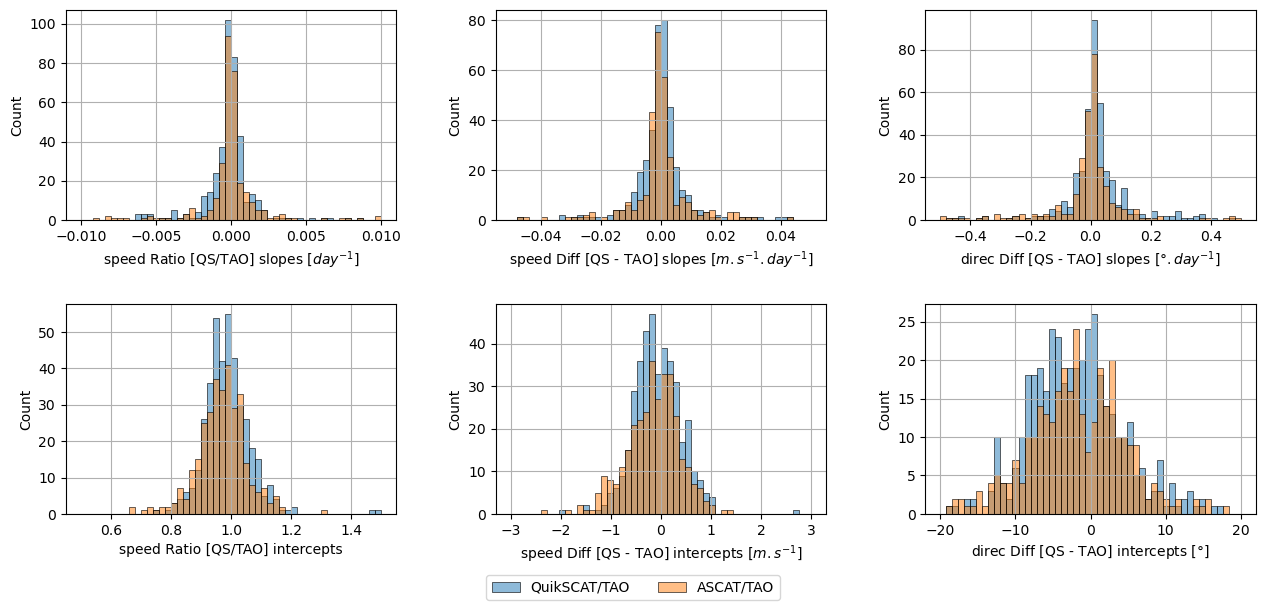

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns

test = allDataDFconcated.loc[abs(allDataDFconcated['LATITUDE']) <= 2]
test1 = allDataDFconcated.loc[allDataDFconcated['LATITUDE'] > 2]
test2 = allDataDFconcated.loc[allDataDFconcated['LATITUDE'] < -2]

xlabel1 = 'speedRatio_slopes'
xlabel2 = 'speedDiff_slopes'
xlabel3 = 'direcDiff_slopes'
xlabel4 = 'speedRatio_intercepts'
xlabel5 = 'speedDiff_intercepts'
xlabel6 = 'direcDiff_intercepts'


fig_xlabel1 = 'speed Ratio [QS/TAO] slopes [$day^{-1}$]'
fig_xlabel2 = 'speed Diff [QS - TAO] slopes [$m.s^{-1}.day^{-1}$]'
fig_xlabel3 = 'direc Diff [QS - TAO] slopes [$\degree.day^{-1}$]'
fig_xlabel4 = 'speed Ratio [QS/TAO] intercepts'
fig_xlabel5 = 'speed Diff [QS - TAO] intercepts [$m.s^{-1}$]'
fig_xlabel6 = 'direc Diff [QS - TAO] intercepts [$\degree$]'

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(14, 6), sharex=False, sharey=False)

labels = ['QuikSCAT/TAO', 'ASCAT/TAO'] #[r'within $\pm 2\degree$ latitude', r'$ > 2\degree$ latitude', r'$< -2\degree$ latitude', 'all locations']
xlabels = [xlabel1, xlabel2, xlabel3, xlabel4, xlabel5, xlabel6]
fig_xlabels = [fig_xlabel1, fig_xlabel2, fig_xlabel3, fig_xlabel4, fig_xlabel5, fig_xlabel6]
xlims = [(-0.02, 0.02), (-0.05, 0.05), (-1, 1), None, None, (-30,25)]

binEdges = [np.linspace(-0.01, 0.01, 51), 
            np.linspace(-0.05, 0.05, 51),
            np.linspace(-0.5, 0.5, 51),
            np.linspace(0.5, 1.5, 51),
            np.linspace(-3, 3, 51),
            np.linspace(-20, 20, 51)
            ]

for i, ax in enumerate(axes.flat):
    #sns.kdeplot(test, x=xlabels[i], ax=ax, label=labels[0])
    #sns.kdeplot(test1, x=xlabels[i], ax=ax, label=labels[1])
    #sns.kdeplot(test2, x=xlabels[i], ax=ax, label=labels[2])
    sns.histplot(allDataDFconcated, x=xlabels[i], bins = binEdges[i], ax=ax, label=labels[0], alpha = 0.5)
    sns.histplot(allDataDFconcated_AS, x=xlabels[i], bins = binEdges[i], ax=ax, label=labels[1], alpha = 0.5)
    
    # if xlims[i] is not None:
    #     ax.set_xlim(xlims[i])
    
    ax.set_xlabel(fig_xlabels[i])
    ax.grid()

# Create a single legend below all plots
handles, labels = axes[1, 2].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=4, fontsize='medium')

# Adjust layout to make space for the legend
plt.subplots_adjust(left= 0.05, hspace=0.4, wspace=0.3, bottom=0.15, top=0.99)

plt.savefig('pdf_of_slopes_intercepts_from_timeSeries.pdf', dpi=100)


In [ ]:
#